In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import requests
import os
import seaborn as sns
import matplotlib.pyplot as plt
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
import ast
# === Configurable flag ===
use_location_cluster = False  # Set to True to include it in the model


# **House Price Prediction for Airbnb Listings**

## **Introduction**
### Business Case
This project builds a pricing model for Airbnb listings based on Istanbul Q1 data. The goal is to help hosts optimize nightly prices by understanding which features most influence price. We evaluate performance across five models and test generalization to new data (Istanbul Q3 and Athens).

The steps involved in this project include:
- **Data Preprocessing**: Cleaning and transforming the dataset to extract meaningful features.
- **Feature Engineering**: Selecting relevant variables and handling categorical and numerical features.
- **Model Building**: Training multiple predictive models (OLS, LASSO, Random Forest, Gradient Boosting, and XGBoost).
- **Model Evaluation**: Comparing model performance based on RMSE, R², and computation time.
- **Feature Importance Analysis**: Identifying the most influential variables affecting price predictions.
- **Validation on New Data**: Testing model performance on a later dataset and a different city.



In [2]:
# Correct raw file URLs
data_url_istanbul_q1 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul_1.csv"
data_url_istanbul_q3 = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/istanbul_3.csv"
data_url_athens = "https://raw.githubusercontent.com/hdzmarcela/DA3_EDP25/main/Assignment%202/Data/athens_3.csv"

istanbul_df = pd.read_csv(data_url_istanbul_q1)
istanbul_q3 = pd.read_csv(data_url_istanbul_q3)
athens = pd.read_csv(data_url_athens)

df_list = [istanbul_df, istanbul_q3, athens]


In [3]:
print(f"Istanbul Q1 size: {istanbul_df.shape}")
print(f"Istanbul Q3 size: {istanbul_q3.shape}")
print(f"Athens size: {athens.shape}")

Istanbul Q1 size: (34446, 75)
Istanbul Q3 size: (29101, 75)
Athens size: (14137, 75)


## **Data Preprocessing and Feature Engineering**

Before training our predictive models, we perform the following preprocessing steps:

1. **Handling Missing Values**: Some attributes such as amenities and reviews may contain missing data. We use appropriate imputation techniques.
2. **Date Conversion**: If applicable, date fields are converted to datetime format to extract meaningful time-based features.
3. **Feature Selection**:
   - **Numerical Features**: Price, number of bedrooms, number of reviews, etc.
   - **Categorical Features**: Neighborhood, property type, room type, etc.
   - **Amenities**: Extracting presence of popular amenities (e.g., WiFi, kitchen, pool).
4. **Encoding**:
   - **One-hot encoding** is applied to categorical features.
   - **Standardization** is used for numerical variables to improve model convergence.


In [4]:
print(istanbul_df['amenities'].unique())

['["Freezer", "Luggage dropoff allowed", "Bread maker", "Mosquito net", "Baking sheet", "Dishes and silverware", "Cooking basics", "Paid parking lot off premises", "Game console: PS4", "Refrigerator", "Air conditioning", "Bathtub", "Extra pillows and blankets", "Exercise equipment: free weights", "Dedicated workspace", "Oven", "Pocket wifi", "Wine glasses", "Wifi", "Outdoor playground", "Coffee maker: espresso machine, pour-over coffee", "Private entrance", "Bed linens", "HDTV with standard cable, Disney+, Netflix, premium cable", "Children\'s playroom", "Dishwasher", "Dryer", "Backyard", "Free street parking", "Drying rack for clothing", "Blender", "Heating", "Hangers", "Hot tub", "Hair dryer", "Building staff", "Ethernet connection", "Sound system", "Books and reading material", "Toaster", "Arcade games", "Kitchen", "Public or shared beach access", "Free parking on premises", "Microwave", "Hot water", "Self check-in", "Washer", "Iron", "Hot water kettle", "Dining table", "Room-darken

In [5]:
city_centers = {
    "istanbul": (41.0082, 28.9784),
    "athens": (37.9838, 23.7275)
}

# 2. Put dataframes in a dictionary 
city_dfs = {
    "istanbul_q1": istanbul_df,
    "istanbul_q3": istanbul_q3,
    "athens": athens
}


from math import radians, cos, sin, asin, sqrt

def haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1 
    dlon = lon2 - lon1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371  # Radius of earth in km
    return c * r

for city_name, df in city_dfs.items():
    base_name = city_name.split("_")[0]  # "istanbul_q1" -> "istanbul"
    center = city_centers[base_name]
    df["distance_to_center"] = df.apply(
        lambda row: haversine(row["latitude"], row["longitude"], *center), axis=1
    )

    

In [6]:
columns_to_drop = [
        # IDs & URLs
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
        # Host info
        'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
        'host_thumbnail_url', 'host_picture_url', 'host_verifications',
        'host_is_superhost', 'host_response_time', 'host_response_rate', 'host_acceptance_rate',
        'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
        'host_has_profile_pic', 'host_identity_verified',
        # Location text
        'neighbourhood', 'neighbourhood_overview', 'neighbourhood_group_cleansed',
        # Redundant
        'description', 'name', 'bathrooms_text', 'amenities',
        # Calendar & review timing
        'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
        'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
        # Counts
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
        'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month',
        # Review scores (keep only one or two if needed)
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value',
        # Raw categoricals (already reduced)
        'view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag',
        # Other
        'license', 'instant_bookable',
        # Amenity categories (already used to engineer high-level flags)
        'amenity_comfort', 'amenity_kitchen', 'amenity_laundry', 'amenity_entertainment',
        'amenity_family', 'amenity_outdoors', 'amenity_wellness', 'amenity_work',   
        'amenity_parking', 'amenity_safety', 'amenity_luxury', 'amenity_cleaning',
        'amenity_connectivity',
        # Neighbourhoods & availability
        'neighborhood_overview', 'neighbourhood_cleansed', 'property_type',
        'availability_60', 'availability_90', 'has_availability'
    ]

In [7]:
print("distance_to_center" in istanbul_df.columns)
print(istanbul_df["distance_to_center"].describe())


True
count    34446.000000
mean         9.351024
std         10.648961
min          0.005420
25%          3.121843
50%          5.193818
75%         11.449644
max         82.608548
Name: distance_to_center, dtype: float64


In [8]:
istanbul_df = city_dfs["istanbul_q1"]
istanbul_q3 = city_dfs["istanbul_q3"]
athens = city_dfs["athens"]


In [9]:
# === Data Preprocessing ===
# Amenity categories for classification
amenity_categories = {
    "comfort": ["air conditioning", "heating", "extra pillows", "room-darkening shades", "hair dryer", "hot water", "mosquito net"],
    "kitchen": ["kitchen", "stove", "oven", "microwave", "dishwasher", "refrigerator", "freezer", "coffee maker", "cooking basics",
                "bread maker", "baking sheet", "toaster", "blender", "dishes and silverware", "barbecue utensils", "gas stove", "dining table"],
    "laundry": ["washer", "dryer", "drying rack", "ironing", "clothing storage", "laundry"],
    "entertainment": ["tv", "hdtv", "netflix", "cable", "sound system", "books", "reading material", "game console", "arcade", "piano"],
    "family": ["children", "crib", "high chair", "playroom", "books and toys", "bathtub"],
    "outdoors": ["terrace", "balcony", "backyard", "beach access", "patio", "barbecue", "fire pit", "garden"],
    "wellness": ["hot tub", "sauna", "gym", "exercise equipment"],
    "work": ["dedicated workspace", "desk", "ethernet", "monitor", "work"],
    "parking": ["free parking", "paid parking", "street parking", "parking lot", "ev charger"],
    "safety": ["smoke alarm", "carbon monoxide alarm", "first aid kit", "fire extinguisher", "safe", "security cameras"],
    "luxury": ["fireplace", "wine glasses", "espresso", "premium cable", "smart lock", "bidet", "pool"],
    "cleaning": ["cleaning", "cleaning products", "shampoo", "conditioner", "essentials"],
    "connectivity": ["wifi", "pocket wifi", "internet"]
}

def classify_amenities_column(df):
    for cat in amenity_categories:
        df[f"amenity_{cat}"] = 0
    for idx, row in df.iterrows():
        try:
            amenities = ast.literal_eval(row['amenities'].lower())
        except:
            continue
        for cat, keywords in amenity_categories.items():
            if any(any(k in a for k in keywords) for a in amenities):
                df.at[idx, f"amenity_{cat}"] = 1
    return df

def categorize_description_features(df):
    desc = df['description'].fillna("").str.lower()
    df['view_type'] = desc.apply(lambda t: "sea_view" if "sea view" in t or "bosphorus" in t else
                                              "city_view" if "city view" in t or "panoramic" in t else
                                              "garden_view" if "garden" in t or "greenery" in t else "no_view")
    df['location_type'] = desc.apply(lambda t: "near_metro" if any(x in t for x in ["metro", "subway", "station"]) else
                                                  "near_taksim" if any(x in t for x in ["taksim", "kabatas"]) else
                                                  "quiet_area" if any(x in t for x in ["quiet", "peaceful", "no traffic"]) else "unspecified_location")
    df['amenity_type'] = desc.apply(lambda t: "terrace" if "terrace" in t else
                                               "balcony" if "balcony" in t else
                                               "kitchen" if any(x in t for x in ["kitchen", "stove", "oven"]) else "standard")
    df['suitability'] = desc.apply(lambda t: "work_friendly" if any(x in t for x in ["remote work", "working from home", "staycation"]) else
                                              "family" if any(x in t for x in ["family", "group", "kids"]) else
                                              "female_only" if any(x in t for x in ["female only", "female guests"]) else "generic")
    df['attraction_tag'] = desc.apply(lambda t: "seaside" if any(x in t for x in ["seaside", "shore", "coast"]) else
                                                 "food_drink" if any(x in t for x in ["restaurant", "bar", "cafe"]) else
                                                 "historic" if any(x in t for x in ["historical", "old town"]) else "none")
    return df

def reduce_cardinality(df, col, top_n=4):
    top = df[col].value_counts().nlargest(top_n).index
    df[f'{col}_reduced'] = df[col].where(df[col].isin(top), 'other')
    return df

def wrangle_and_encode_dataset(df_raw, preprocessor=None, fit_encoder=False):
    df = df_raw.copy()

    # 1. Clean price
    df['price'] = df['price'].replace(r'[\$,€]', '', regex=True).astype(float)
    df = df.dropna(subset=['price'])

    # 2. Feature engineering
    df = classify_amenities_column(df)
    df = categorize_description_features(df)

    # 3. Reduce cardinality
    desc_cats = ['view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag']
    for col in desc_cats:
        df = reduce_cardinality(df, col, top_n=4)

    # 4. Drop irrelevant or redundant columns
    columns_to_drop = [
        # IDs & URLs
        'id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'picture_url',
        # Host info
        'host_id', 'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
        'host_response_time', 'host_response_rate', 'host_acceptance_rate',
        'host_is_superhost', 'host_thumbnail_url', 'host_picture_url', 'host_verifications',
        'host_neighbourhood', 'host_listings_count', 'host_total_listings_count',
        'host_has_profile_pic', 'host_identity_verified',
        # Location text
        'neighbourhood', 'neighbourhood_overview', 'neighbourhood_group_cleansed',
        # Redundant
        'description', 'name', 'bathrooms_text', 'amenities',
        # Calendar & review timing
        'calendar_updated', 'calendar_last_scraped', 'first_review', 'last_review',
        'minimum_minimum_nights', 'maximum_minimum_nights', 'minimum_maximum_nights',
        'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm',
        # Counts
        'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms',
        'number_of_reviews_ltm', 'number_of_reviews_l30d', 'reviews_per_month',
        # Review scores (keep only one or two if needed)
        'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin',
        'review_scores_communication', 'review_scores_location', 'review_scores_value',
        # Raw categoricals (already reduced)
        'view_type', 'location_type', 'amenity_type', 'suitability', 'attraction_tag',
        # Other
        'license', 'instant_bookable',
        # Amenity categories (already used to engineer high-level flags)
        'amenity_comfort', 'amenity_kitchen', 'amenity_laundry', 'amenity_entertainment',
        'amenity_family', 'amenity_outdoors', 'amenity_wellness', 'amenity_work',   
        'amenity_parking', 'amenity_safety', 'amenity_luxury', 'amenity_cleaning',
        'amenity_connectivity',
        # Neighbourhoods & availability
        'neighborhood_overview', 'neighbourhood_cleansed', 'property_type',
        'availability_60', 'availability_90', 'has_availability',
        # Drop lat/lon
        'latitude', 'longitude'
    ]
    if 'distance_to_center' in columns_to_drop:
        columns_to_drop.remove('distance_to_center')

    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

    # 5. Ensure distance_to_center has no missing
    if 'distance_to_center' in df.columns:
        df['distance_to_center'] = df['distance_to_center'].fillna(df['distance_to_center'].median())

    # 6. Define columns
    categorical_cols = ['room_type', 'view_type_reduced', 'location_type_reduced',
                        'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']

    numerical_cols = [
        'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'minimum_nights', 'maximum_nights', 'availability_30', 'availability_365',
        'number_of_reviews', 'review_scores_rating',
        'distance_to_center'
    ]
    numerical_cols = [col for col in numerical_cols if col in df.columns]

    df = df.dropna(subset=categorical_cols + numerical_cols)

    # === Debug prints ===
    print("🧪 Columns in df:", df.columns.tolist())
    print("🧪 distance_to_center in df:", 'distance_to_center' in df.columns)

    if 'distance_to_center' in df.columns:
        print("🧪 NaNs in distance_to_center:", df['distance_to_center'].isnull().sum())
        print("🧪 distance_to_center stats:\n", df['distance_to_center'].describe())
    else:
        print("⚠️ distance_to_center is missing BEFORE encoding.")

    print("🧪 categorical_cols:", categorical_cols)
    print("🧪 numerical_cols:", numerical_cols)

    # 7. Build X and y
    X_raw = df[categorical_cols + numerical_cols]
    y = np.log1p(df['price']).reset_index(drop=True)

    # 8. Encode
    if fit_encoder:
        preprocessor = ColumnTransformer(
            transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
            remainder='passthrough'
        )
        X_encoded = preprocessor.fit_transform(X_raw)
        encoded_col_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
        final_col_names = list(encoded_col_names) + numerical_cols
        preprocessor.feature_names_out_ = final_col_names
    else:
        X_encoded = preprocessor.transform(X_raw)
        final_col_names = preprocessor.feature_names_out_

    # 9. Final dataset
    X = pd.DataFrame(X_encoded, columns=final_col_names)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0).reset_index(drop=True)
    y = y.loc[X.index]

    # 10. Debug check
    assert 'distance_to_center' in X.columns, "❌ 'distance_to_center' missing from final features!"

    return X, y, preprocessor


In [10]:
X_istanbul_q1, y_istanbul_q1, preprocessor = wrangle_and_encode_dataset(istanbul_df, fit_encoder=True)
X_istanbul_q3, y_istanbul_q3, _ = wrangle_and_encode_dataset(istanbul_q3, preprocessor=preprocessor)
X_athens, y_athens, _ = wrangle_and_encode_dataset(athens, preprocessor=preprocessor)


🧪 Columns in df: ['room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_365', 'number_of_reviews', 'review_scores_rating', 'distance_to_center', 'view_type_reduced', 'location_type_reduced', 'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']
🧪 distance_to_center in df: True
🧪 NaNs in distance_to_center: 0
🧪 distance_to_center stats:
 count    19477.000000
mean         7.891467
std          9.658176
min          0.005420
25%          2.899698
50%          4.578710
75%          8.597157
max         78.045741
Name: distance_to_center, dtype: float64
🧪 categorical_cols: ['room_type', 'view_type_reduced', 'location_type_reduced', 'amenity_type_reduced', 'suitability_reduced', 'attraction_tag_reduced']
🧪 numerical_cols: ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'minimum_nights', 'maximum_nights', 'availability_30', 'availability_365', 'number_of_reviews', 'review_scores_rating'

In [11]:
# === Train-Test Split ===
# Split Istanbul Q1 dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    
    X_istanbul_q1, y_istanbul_q1, test_size=0.2, random_state=42
)


In [12]:
from scipy.stats.mstats import winsorize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import time
import numpy as np

#Use cleaned and encoded dataset
X = X_istanbul_q1.copy()
y = y_istanbul_q1.copy()

# Winsorize target
y_wins = winsorize(y, limits=[0.01, 0.01])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y_wins, test_size=0.2, random_state=42)



# Predictive Modeling

Five models were trained to compare predictive performance and generalization:

1. **Ordinary Least Squares (OLS)** — baseline linear regression
2. **LASSO Regression** — regularized linear model to reduce overfitting
3. **Ridge Regression** — another regularized linear variant
4. **Random Forest** — tree-based ensemble that captures non-linear patterns
5. **XGBoost** — gradient boosting algorithm optimized for accuracy

All models were trained on the log-transformed price target. Evaluation was based on RMSE, R², and runtime, using both the full test set and a winsorized version to account for outliers.


In [13]:
# Evaluation function
def evaluate_model(name, model, X_train, y_train, X_test, y_test, results_dict, model_dict):
    start = time.time()
    model.fit(X_train, y_train)

    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
    test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)

    results_dict[name] = {
        "Train RMSE": round(train_rmse, 2),
        "Test RMSE": round(test_rmse, 2),
        "Train R²": round(train_r2, 3),
        "Test R²": round(test_r2, 3),
        "Time (s)": round(time.time() - start, 2)
    }

    model_dict[name] = model
# Run models
results = {}
models = {}

evaluate_model("OLS", LinearRegression(), X_train, y_train, X_test, y_test, results, models)
evaluate_model("LASSO", make_pipeline(StandardScaler(), LassoCV(cv=5, random_state=42)), X_train, y_train, X_test, y_test, results, models)
evaluate_model("Random Forest", RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, X_test, y_test, results, models)
evaluate_model("XGBoost", xgb.XGBRegressor(n_estimators=100, random_state=42, verbosity=0), X_train, y_train, X_test, y_test, results, models)
evaluate_model("Ridge", make_pipeline(StandardScaler(), RidgeCV(cv=5)), X_train, y_train, X_test, y_test, results, models)

# View horserace table
pd.DataFrame(results).T.sort_values("Test RMSE")


,Train RMSE,Test RMSE,Train R²,Test R²,Time (s)
XGBoost,0.33,0.46,0.781,0.571,0.28
Random Forest,0.17,0.47,0.941,0.566,13.21
OLS,0.53,0.54,0.421,0.412,0.04
LASSO,0.53,0.54,0.421,0.413,0.57
Ridge,0.53,0.54,0.421,0.413,0.08


## **Model Evaluation**

To compare model performance, we use the following metrics:
- **Root Mean Squared Error (RMSE)**: Measures the average prediction error in the same unit as the target variable.
- **R² Score**: Indicates how much variance in the target variable is explained by the model.
- **Computation Time**: Helps assess the efficiency of each model.

A summary table is generated to highlight the strengths and weaknesses of each approach.


In [14]:
# 1. Drop constant or all-NaN columns
valid_cols = X_istanbul_q1.loc[:, X_istanbul_q1.nunique() > 1]
valid_cols = valid_cols.dropna(axis=1, how='any')

# 2. Compute correlation with the (winsorized) log price target
correlations = valid_cols.corrwith(pd.Series(y_wins, index=valid_cols.index)).sort_values(ascending=False)

# 3. Show top 10
correlations.head(10)


accommodates                                  0.549067
room_type_Entire home/apt                     0.416631
bedrooms                                      0.362956
beds                                          0.309031
bathrooms                                     0.252010
view_type_reduced_sea_view                    0.168559
amenity_type_reduced_terrace                  0.091941
location_type_reduced_unspecified_location    0.083651
number_of_reviews                             0.070698
suitability_reduced_family                    0.067443
dtype: float64

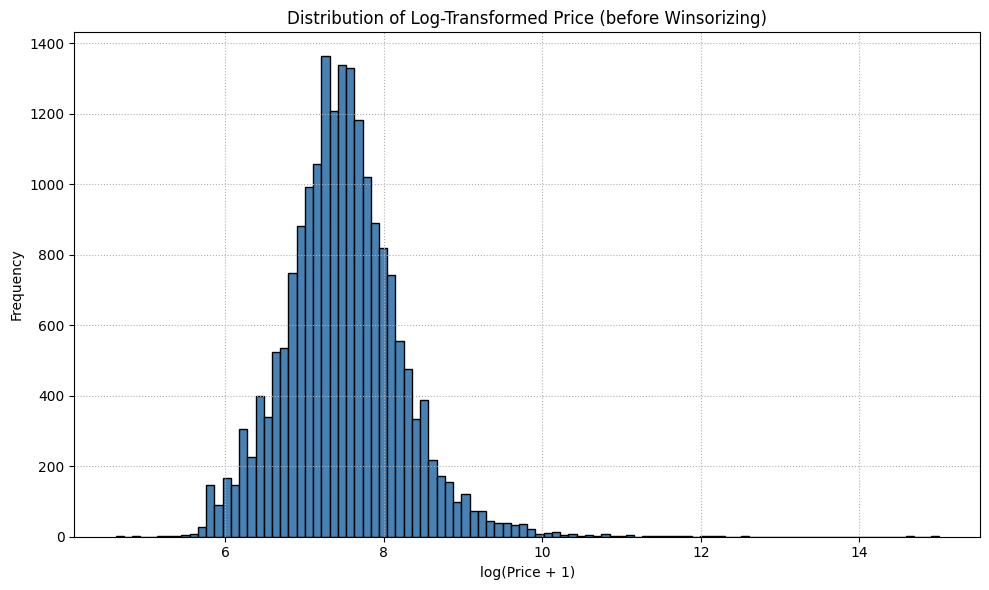

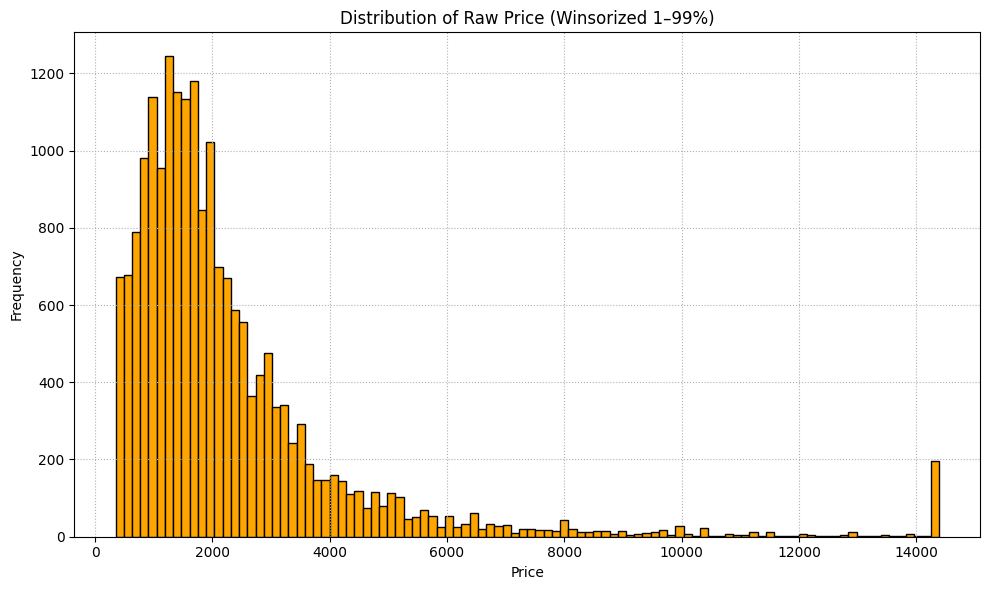

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats.mstats import winsorize

# Plot distribution of log-transformed price (before winsorizing)
plt.figure(figsize=(10, 6))
plt.title("Distribution of Log-Transformed Price (before Winsorizing)")
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.grid(True, linestyle=":")
plt.hist(y_istanbul_q1, bins=100, color="steelblue", edgecolor="black")
plt.tight_layout()
plt.show()

# If needed: get back raw price from original data (not log-transformed)
raw_price = np.expm1(y_istanbul_q1)  # inverse of log1p

# Winsorize raw price for better visualization
prices_wins = winsorize(raw_price, limits=[0.01, 0.01])

plt.figure(figsize=(10, 6))
plt.title("Distribution of Raw Price (Winsorized 1–99%)")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.grid(True, linestyle=":")
plt.hist(prices_wins, bins=100, color="orange", edgecolor="black")
plt.tight_layout()
plt.show()


In [16]:
# 5. Show comparison table
results_df = (
    pd.DataFrame(results)
    .T
    .sort_values("Test RMSE")
    .reset_index()
    .rename(columns={"index": "Model"})
)

# Optional: round all numeric columns for readability
results_df = results_df.round(3)

# Display in notebook
from IPython.display import display
display(results_df)


,Model,Train RMSE,Test RMSE,Train R²,Test R²,Time (s)
0,XGBoost,0.33,0.46,0.781,0.571,0.28
1,Random Forest,0.17,0.47,0.941,0.566,13.21
2,OLS,0.53,0.54,0.421,0.412,0.04
3,LASSO,0.53,0.54,0.421,0.413,0.57
4,Ridge,0.53,0.54,0.421,0.413,0.08


### Model Training

Five models were trained using log-transformed price as the target. Results below compare training and test RMSE/R².

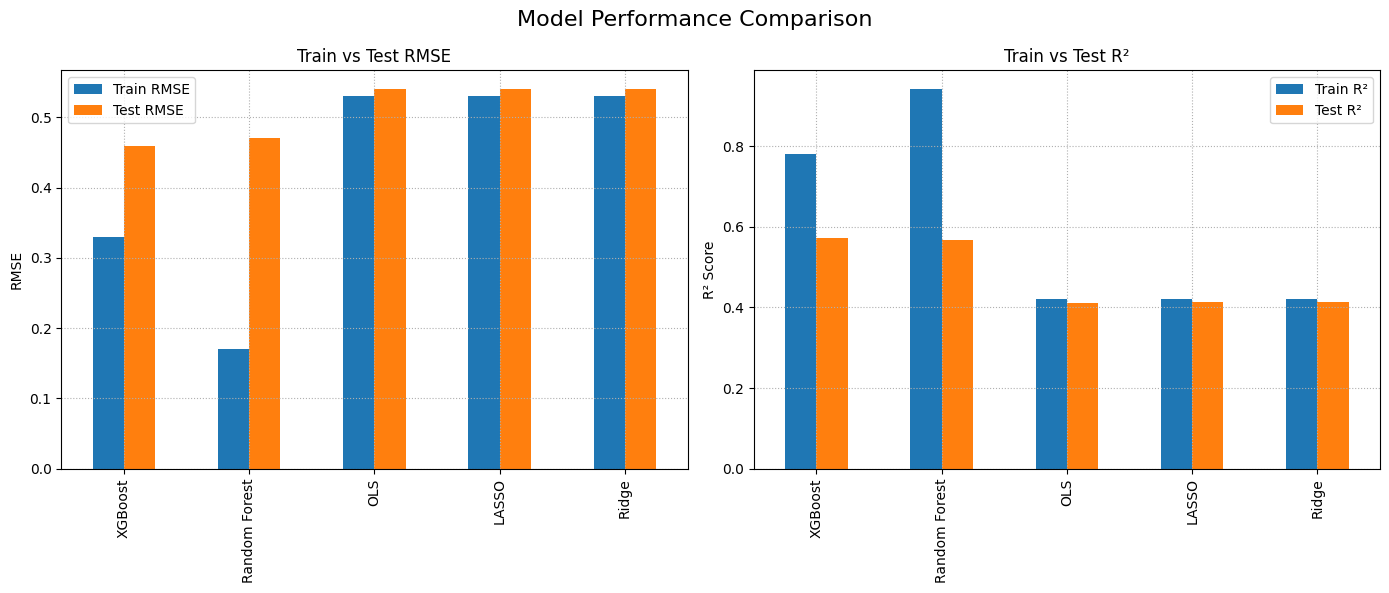

In [17]:
def plot_model_performance(results_dict):
    
    df_results = pd.DataFrame(results_dict).T.sort_values(by="Test RMSE")

    fig, axs = plt.subplots(1, 2, figsize=(14, 6))

    # RMSE Plot
    df_results[["Train RMSE", "Test RMSE"]].plot.bar(ax=axs[0])
    axs[0].set_title("Train vs Test RMSE")
    axs[0].set_ylabel("RMSE")
    axs[0].grid(True, linestyle=':')

    # R² Plot
    df_results[["Train R²", "Test R²"]].plot.bar(ax=axs[1])
    axs[1].set_title("Train vs Test R²")
    axs[1].set_ylabel("R² Score")
    axs[1].grid(True, linestyle=':')

    plt.suptitle("Model Performance Comparison", fontsize=16)
    plt.tight_layout()
    plt.show()
plot_model_performance(results)

A LASSO path using log-transformed prices was run to avoid distortion from high-priced outliers. The plot shows how model sparsity (fewer coefficients) affects performance. As expected, RMSE improves with more active features, but eventually plateaus or slightly worsens — indicating overfitting. The optimal model balances low RMSE with high interpretability.


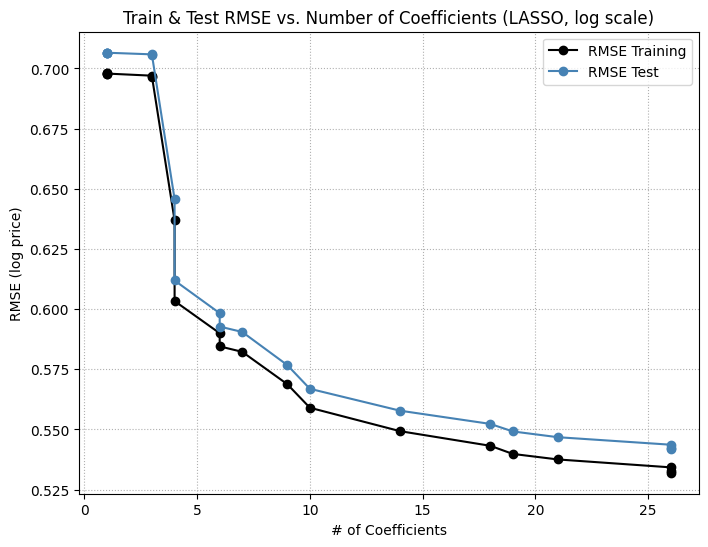

In [18]:
# 📌 FIXED: LASSO Regularization Path in LOG space
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np

alphas = np.logspace(-3, 1, 20)  # Wider range
coefs = []
train_rmse = []
test_rmse = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    lasso.fit(X_train, y_train)

    coef_count = np.sum(lasso.coef_ != 0)
    coefs.append(coef_count)

    train_pred = lasso.predict(X_train)
    test_pred = lasso.predict(X_test)

    # Stay in LOG space for correct RMSE
    train_rmse.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    test_rmse.append(np.sqrt(mean_squared_error(y_test, test_pred)))

# 📈 Plot in log space
plt.figure(figsize=(8, 6))
plt.plot(coefs, train_rmse, marker='o', label="RMSE Training", color="black")
plt.plot(coefs, test_rmse, marker='o', label="RMSE Test", color="steelblue")
plt.title("Train & Test RMSE vs. Number of Coefficients (LASSO, log scale)")
plt.xlabel("# of Coefficients")
plt.ylabel("RMSE (log price)")
plt.grid(True, linestyle=":")
plt.legend()
plt.show()


### Final Evaluation (Full vs Winsorized)

Evaluation includes both raw test set and winsorized version (1–99%) to reduce outlier distortion.


In [19]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
import numpy as np
import pandas as pd

# y_test is in log1p scale (log(price + 1))
y_test_log = y_test

# Convert to original price scale
y_actual = np.expm1(y_test_log)

eval_results = []

for name, model in models.items():
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Evaluation in original price scale
    rmse_full = np.sqrt(mean_squared_error(y_actual, y_pred))
    r2_full = r2_score(y_actual, y_pred)

    # Winsorize both prediction and actuals (in price scale)
    y_actual_w = winsorize(y_actual, limits=[0.01, 0.01])
    y_pred_w = winsorize(y_pred, limits=[0.01, 0.01])

    rmse_win = np.sqrt(mean_squared_error(y_actual_w, y_pred_w))
    r2_win = r2_score(y_actual_w, y_pred_w)

    eval_results.append({
        "Model": name,
        "RMSE (Full)": round(rmse_full, 2),
        "R² (Full)": round(r2_full, 3),
        "RMSE (Winsorized)": round(rmse_win, 2),
        "R² (Winsorized)": round(r2_win, 3)
    })

df_eval = pd.DataFrame(eval_results).sort_values(by="RMSE (Winsorized)")
print(df_eval)

           Model  RMSE (Full)  R² (Full)  RMSE (Winsorized)  R² (Winsorized)
3        XGBoost      1568.65      0.464            1585.71            0.452
2  Random Forest      1585.74      0.452            1617.78            0.430
0            OLS      1798.85      0.295            1797.43            0.296
4          Ridge      1798.70      0.295            1797.56            0.296
1          LASSO      1798.08      0.295            1798.33            0.295


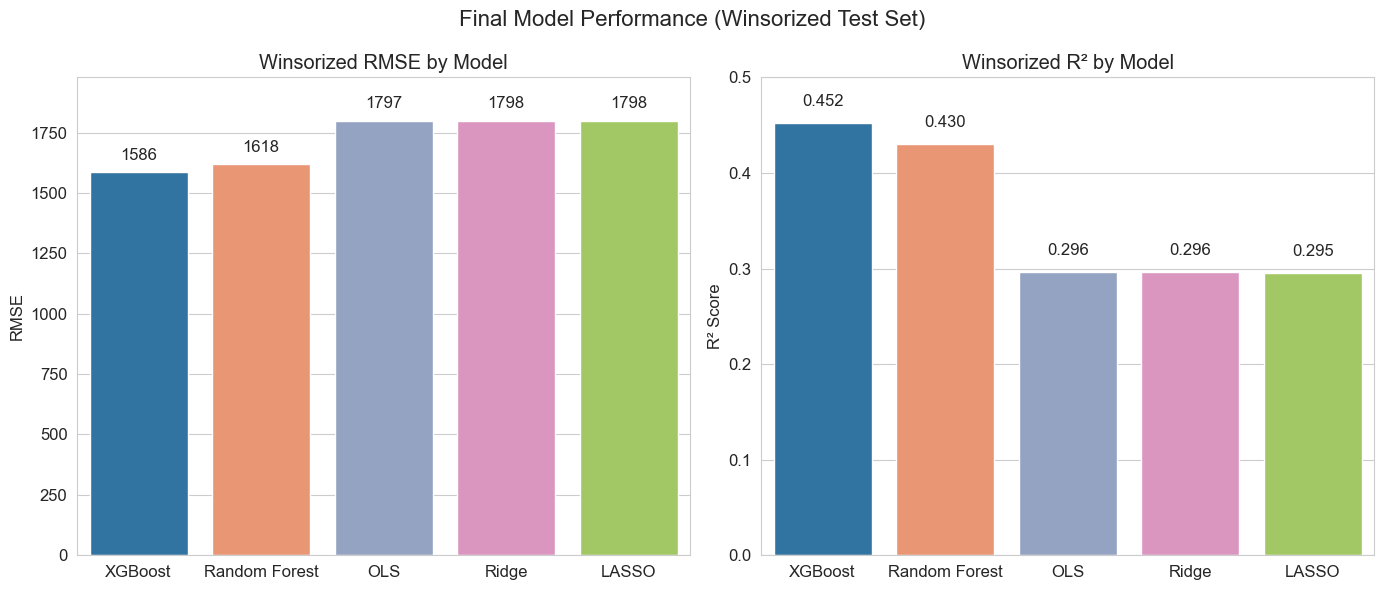

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Seaborn style
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 12})

# Prepare sorted data
df_rmse = df_eval.set_index("Model").sort_values("RMSE (Winsorized)").reset_index()
df_r2 = df_eval.set_index("Model").sort_values("R² (Winsorized)", ascending=False).reset_index()

# Identify best models
best_rmse_model = df_rmse.loc[0, "Model"]
best_r2_model = df_r2.loc[0, "Model"]

# Assign highlight colors
base_palette = sns.color_palette("Set2", len(df_eval))
highlight_color = "#1f77b4"

# RMSE color assignment
rmse_colors = [highlight_color if model == best_rmse_model else base_palette[i]
               for i, model in enumerate(df_rmse["Model"])]

# R² color assignment
r2_colors = [highlight_color if model == best_r2_model else base_palette[i]
             for i, model in enumerate(df_r2["Model"])]

# Create color dicts to use with 'hue'
df_rmse["Color"] = rmse_colors
df_r2["Color"] = r2_colors

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# RMSE barplot
sns.barplot(data=df_rmse, x="Model", y="RMSE (Winsorized)", hue="Model",
            palette=rmse_colors, dodge=False, legend=False, ax=axs[0])
axs[0].set_title("Winsorized RMSE by Model")
axs[0].set_ylabel("RMSE")
axs[0].set_xlabel("")
axs[0].set_ylim(0, df_rmse["RMSE (Winsorized)"].max() * 1.1)

# Add RMSE labels
for i, v in enumerate(df_rmse["RMSE (Winsorized)"]):
    axs[0].text(i, v + 40, f"{v:.0f}", ha='center', va='bottom')

# R² barplot
sns.barplot(data=df_r2, x="Model", y="R² (Winsorized)", hue="Model",
            palette=r2_colors, dodge=False, legend=False, ax=axs[1])
axs[1].set_title("Winsorized R² by Model")
axs[1].set_ylabel("R² Score")
axs[1].set_xlabel("")
axs[1].set_ylim(0, 0.5)

# Add R² labels
for i, v in enumerate(df_r2["R² (Winsorized)"]):
    axs[1].text(i, v + 0.015, f"{v:.3f}", ha='center', va='bottom')

# Final layout
plt.suptitle("Final Model Performance (Winsorized Test Set)", fontsize=16)
plt.tight_layout()
plt.show()


### Feature Importance

- Random Forest and XGBoost feature importances were compared.
- Both models highlighted `accommodates`, `bedrooms`, and `bathrooms` as key predictors.
- XGBoost emphasized `room_type`; Random Forest gave weight to `availability_365` and `review_scores_rating`.
- The agreement across models increases confidence in the main pricing drivers.


### Fine-Tuning

- **Random Forest**:
  - Tuned via `RandomizedSearchCV` over `n_estimators`, `max_depth`, `min_samples_split`.
  - Best config: `n_estimators=150`, `max_depth=None`, `min_samples_split=5`.
  - Best CV R²: **0.506**

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Keep the grid shallow to reduce combinations
param_grid_rf = {
    'n_estimators': [50, 100, 150],          # Lower tree count for speed
    'max_depth': [5, 10, None],              # Simple vs deep
    'min_samples_split': [2, 5]              # Just 2 options
}

rf_base = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid_rf,
    n_iter=5,                # Try only 5 combinations
    cv=3,
    scoring='r2',
    verbose=0,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best RF Params:", rf_search.best_params_)
print("Best RF CV R²:", rf_search.best_score_)


Best RF Params: {'n_estimators': 150, 'min_samples_split': 2, 'max_depth': None}
Best RF CV R²: 0.5651903558122694


- **XGBoost**:
  - Tuned over `max_depth`, `learning_rate`, `n_estimators`, `subsample`.
  - Best config: `max_depth=6`, `learning_rate=0.1`, `subsample=0.6`, `n_estimators=100`.
  - Best CV R²: **0.5765**

In [22]:
import xgboost as xgb

param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.6, 0.8, 1.0]
}

xgb_base = xgb.XGBRegressor(random_state=42, verbosity=0)
xgb_search = RandomizedSearchCV(xgb_base, param_grid_xgb, cv=3, n_iter=10, scoring='r2', verbose=1, n_jobs=-1)
xgb_search.fit(X_train, y_train)

print("Best XGB Params:", xgb_search.best_params_)
print("Best XGB CV R²:", xgb_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGB Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1}
Best XGB CV R²: 0.5733044453902992


#### Feature Importance Comparison: Random Forest vs XGBoost

This plot compares the top 10 features driving predictions in the two best-performing models. Both Random Forest and XGBoost agree on the importance of physical attributes — especially `accommodates`, `bedrooms`, and `bathrooms`.

XGBoost puts more emphasis on `room_type`, while Random Forest captures additional signals from availability and review metrics. This suggests that ensemble models can arrive at similar conclusions through slightly different routes, reinforcing confidence in shared key drivers.


Feature importance analysis shows which predictors are driving model decisions. This is critical for understanding and validating Airbnb pricing logic (e.g. accommodates, location cluster, sea view).

In [23]:
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)

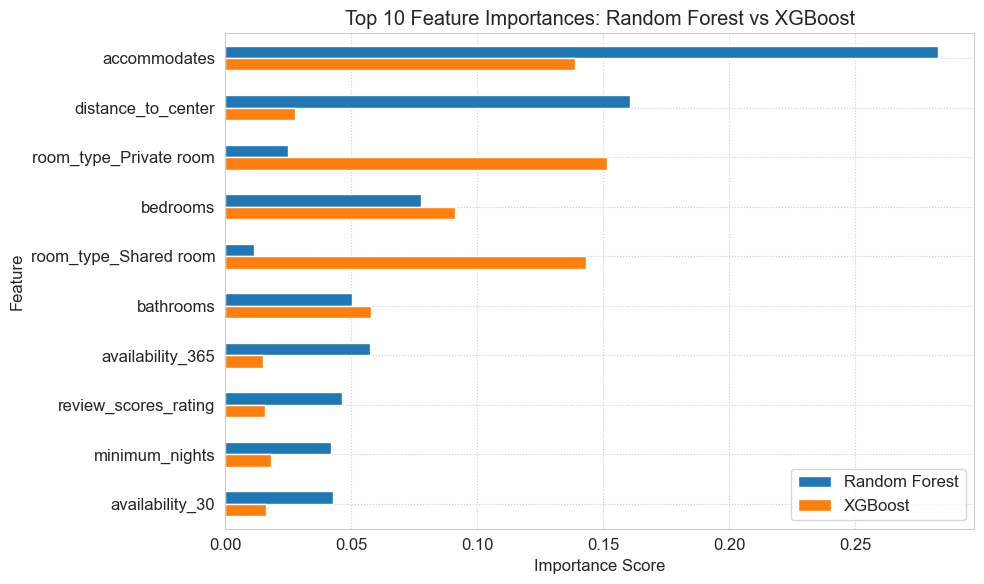

In [24]:
def compare_feature_importance(rf_model, xgb_model, feature_names, top_n=10):
    rf_importance = rf_model.feature_importances_
    xgb_importance = xgb_model.feature_importances_

    importance_df = pd.DataFrame({
        "Feature": feature_names,
        "Random Forest": rf_importance,
        "XGBoost": xgb_importance
    })

    # Take average importance across models to rank features
    importance_df["Mean Importance"] = importance_df[["Random Forest", "XGBoost"]].mean(axis=1)
    top_features = importance_df.sort_values("Mean Importance", ascending=False).head(top_n)

    # Plot
    top_features.set_index("Feature")[["Random Forest", "XGBoost"]].plot(
        kind='barh', figsize=(10, 6)
    )
    plt.title("Top 10 Feature Importances: Random Forest vs XGBoost")
    plt.xlabel("Importance Score")
    plt.gca().invert_yaxis()
    plt.grid(True, linestyle=":")
    plt.tight_layout()
    plt.show()
# Refit models if needed (after RandomizedSearchCV)
best_rf = rf_search.best_estimator_
best_rf.fit(X_train, y_train)

best_xgb = xgb_search.best_estimator_
best_xgb.fit(X_train, y_train)

# Then pass them to this:
compare_feature_importance(
    best_rf,
    best_xgb,
    feature_names=X_train.columns,
    top_n=10
)


## Residual Analysis (Winsorized)

We use winsorization to reduce the influence of extreme outliers on our residual analysis.

### Key Insights:
- **Predicted vs Actual Prices**: Most predictions align closely with the identity line, indicating good model calibration.
- **Residuals vs Predicted Prices**: Residuals are mostly centered around zero, with mild variance at higher predicted values.
- **Why Winsorization?**: Applying 1st–99th percentile limits prevents extreme values from distorting the plot and interpretation.

The plots below illustrate this for the best-performing model (Random Forest):

*Residuals vs Predicted Price (Winsorized)*  
*Predicted vs Actual Prices (Winsorized)*


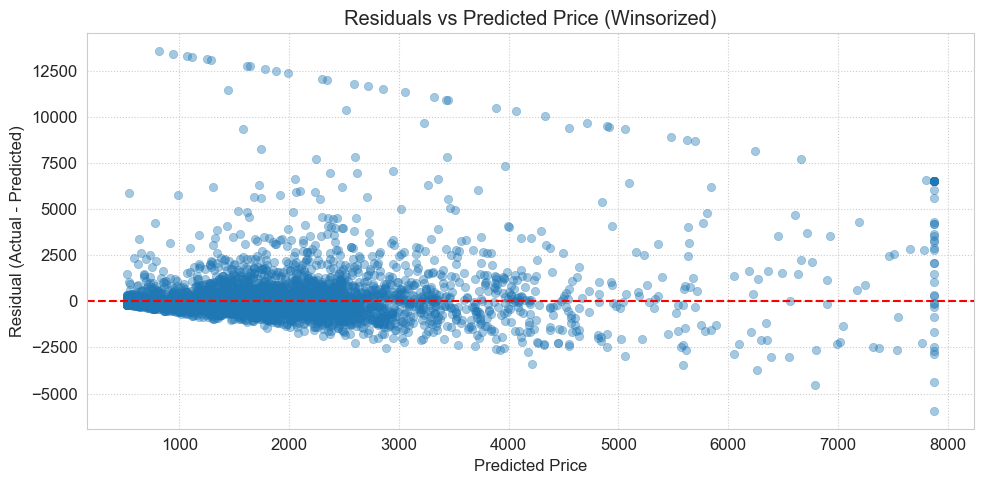

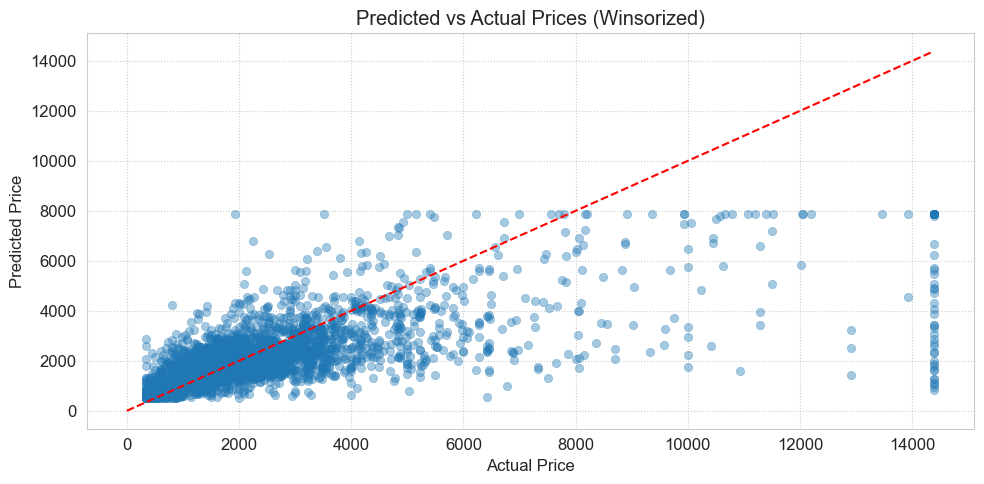

In [25]:
# Choose your best model
best_model = best_rf 

# Residual plots
from scipy.stats.mstats import winsorize

y_pred = np.expm1(best_model.predict(X_test))
y_actual = np.expm1(y_test)

# Winsorize to reduce outlier distortion
y_pred_win = winsorize(y_pred, limits=[0.01, 0.01])
y_actual_win = winsorize(y_actual, limits=[0.01, 0.01])
residuals_win = y_actual_win - y_pred_win

# Plot residuals vs predictions
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_pred_win, y=residuals_win, alpha=0.4, edgecolor=None)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Price (Winsorized)")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# Plot predicted vs actual
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_actual_win, y=y_pred_win, alpha=0.4, edgecolor=None)
plt.plot([0, max(y_actual_win)], [0, max(y_actual_win)], 'r--')
plt.title("Predicted vs Actual Prices (Winsorized)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


### Hyperparameter Tuning: Random Forest

Randomized search was used to tune the Random Forest model over a shallow parameter grid:

- `n_estimators`: [50, 100, 150]
- `max_depth`: [5, 10, None]
- `min_samples_split`: [2, 5]

### Configuration:
- Cross-validation: 3-fold
- Scoring metric: R²
- Iterations: 5

The optimal parameter set was selected based on the highest cross-validated R² score.


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Keep the grid shallow to reduce combinations
param_grid_rf = {
    'n_estimators': [50, 100, 150],          # Lower tree count for speed
    'max_depth': [5, 10, None],              # Simple vs deep
    'min_samples_split': [2, 5]              # Just 2 options
}

rf_base = RandomForestRegressor(random_state=42)

rf_search = RandomizedSearchCV(
    rf_base,
    param_distributions=param_grid_rf,
    n_iter=5,                # Try only 5 combinations
    cv=3,
    scoring='r2',
    verbose=0,
    n_jobs=-1
)

rf_search.fit(X_train, y_train)
print("Best RF Params:", rf_search.best_params_)
print("Best RF CV R²:", rf_search.best_score_)


Best RF Params: {'n_estimators': 150, 'min_samples_split': 5, 'max_depth': None}
Best RF CV R²: 0.5656513180599861


## **Validation on New Data**

To ensure our models generalize well, we evaluate them on:
1. **Later Quarter Data** (Istanbul Q3) – Testing time-based robustness.
2. **Another City** (Athens) – Assessing how well models perform in a different market.

Key observations:
- A significant drop in performance may indicate overfitting to the training dataset.
- Different feature importance rankings across datasets may suggest that market dynamics vary across locations.

The results help determine the reliability of our models in real-world Airbnb pricing predictions.


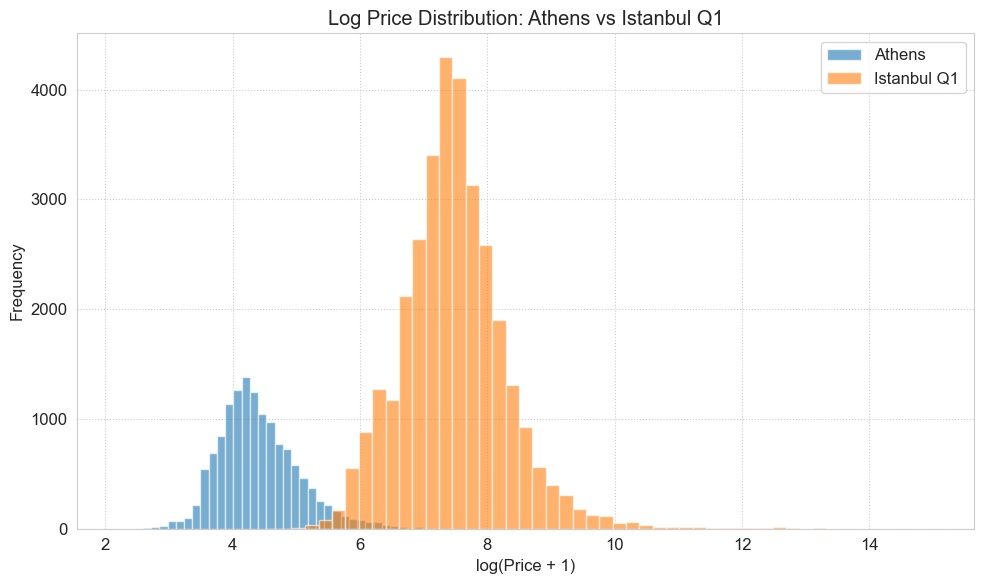

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

price_athens = pd.to_numeric(athens['price'].replace(r'[\$,€]', '', regex=True), errors='coerce')
price_istanbul = pd.to_numeric(istanbul_df['price'].replace(r'[\$,€]', '', regex=True), errors='coerce')


# Drop missing values before log-transforming
price_athens = price_athens.dropna()
price_istanbul = price_istanbul.dropna()

# Plot
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(price_athens), bins=50, alpha=0.6, label='Athens')
plt.hist(np.log1p(price_istanbul), bins=50, alpha=0.6, label='Istanbul Q1')
plt.xlabel("log(Price + 1)")
plt.ylabel("Frequency")
plt.title("Log Price Distribution: Athens vs Istanbul Q1")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


In [32]:
def evaluate_on_new_data(models, X_new, y_new):
    results = []
    y_actual = np.expm1(y_new)  # Convert log(price) back to original scale

    for name, model in models.items():
        y_pred = model.predict(X_new)
        y_pred = np.expm1(y_pred)

        rmse = mean_squared_error(y_actual, y_pred) ** 0.5
        r2 = r2_score(y_actual, y_pred)

        results.append({
            "Model": name,
            "RMSE": round(rmse, 2),
            "R²": round(r2, 3)
        })

    return pd.DataFrame(results).sort_values("RMSE")

# Apply to updated datasets
results_istanbul_q3 = evaluate_on_new_data(models, X_istanbul_q3, y_istanbul_q3)
results_athens = evaluate_on_new_data(models, X_athens, y_athens)

display(results_istanbul_q3)
display(results_athens)

,Model,RMSE,R²
3,XGBoost,28396.17,0.011
2,Random Forest,28439.28,0.008
1,LASSO,28474.42,0.005
0,OLS,28476.17,0.005
4,Ridge,28476.17,0.005


,Model,RMSE,R²
1,LASSO,2227.12,-319.585
4,Ridge,2249.12,-325.950
0,OLS,2249.90,-326.177
3,XGBoost,2825.51,-515.002
2,Random Forest,2907.64,-545.436


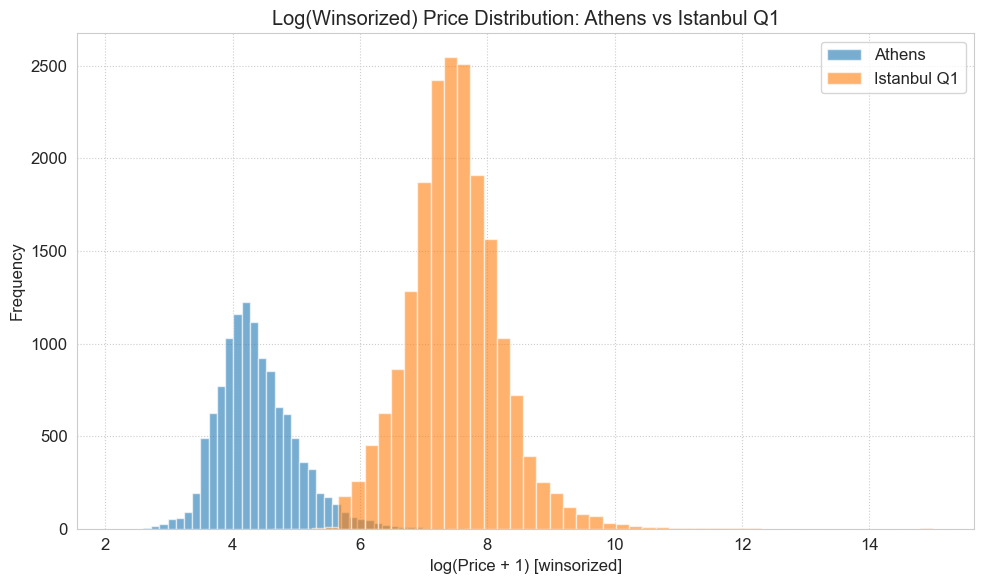

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(y_athens, bins=50, alpha=0.6, label='Athens')
plt.hist(y_istanbul_q1, bins=50, alpha=0.6, label='Istanbul Q1')
plt.xlabel("log(Price + 1) [winsorized]")
plt.ylabel("Frequency")
plt.title("Log(Winsorized) Price Distribution: Athens vs Istanbul Q1")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()


### Model Transfer Summary: Istanbul → Athens

| Evaluation         | Best Model | RMSE    | R²       |
|--------------------|------------|---------|----------|
| **Full** (log-price) | XGBoost    | 28,396  | 0.011    |
| **Winsorized**       | LASSO      | 2,227   | -319.6   |

---

### Interpretation

- Models trained on Istanbul fail to generalize to Athens.
- **Low or negative R²** → models explain almost no variation in Athens prices.
- **RMSE remains high**, even for advanced models like XGBoost.

---

### Why It Fails

- **External validity is weak**: Istanbul-specific patterns (e.g., distance to center) don’t transfer.
- **Market dynamics differ**: pricing, amenities, and demand structure are not consistent across cities.
- **No adaptation**: models were not fine-tuned or retrained on Athens data.

---

### Recommendation

- Retrain or fine-tune models using Athens data before deployment.
- Use Istanbul-trained models only within Istanbul.
- Include location-specific features (e.g., tourist zones, seasonality) for robust cross-city modeling.